In [1]:
"""
                                PROCESAMIENDO DIGITAL DE SEÑALES: TP2

                                Alumno: Julián Luongo

                                Software Utilizado: Visual Studio Code,Lenguaje Python

                                Hardware:
                                CPU: Intel Core i5 12600k
                                Ram:16gb
"""
from pylab import *
from pylab import zeros
import math
import random
import struct
from scipy import signal as sg
import scipy
from scipy import special as sp
import numpy as np
from numpy.fft import rfft, irfft
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import cv2
import scipy.io.wavfile as wav
import IPython
from collections import Counter

In [2]:
''' SE RECOMIENDA BORRAR TODAS LAS VARIABLES ANTES DE EJECUTAR EL CÓDIGO '''

#SE DEFINEN LAS FUNCIONES A UTILIZAR:

def most_frequent(List):

    'Program to find most frequent element in a list'

    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]


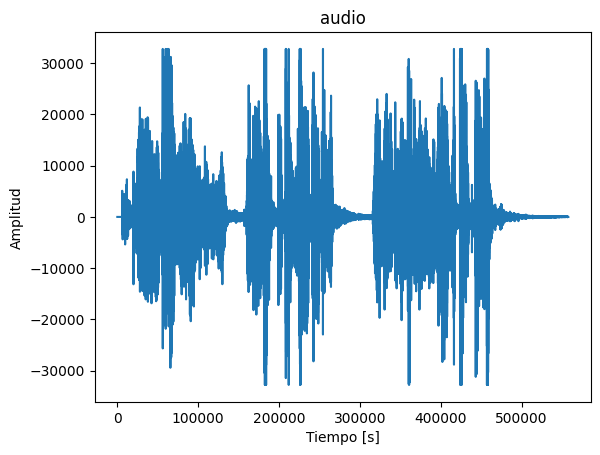

frecuencia de muestreo : 44100


In [3]:
'''
PROCEDIMIENTO PARA WATERMARKING
'''

#PASO 1: cargar el audio

audio_location=r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\speech.wav'      #CAMBIAR ACA LA UBICACION DEL AUDIO PARA EL PROCESO

fs_audio, audio = wav.read(audio_location)

n=np.arange(0,len(audio))

plt.figure()
plt.plot(n,audio)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.title('audio')  
plt.show()

print('frecuencia de muestreo : ' + str(fs_audio))
IPython.display.Audio("speech.wav")                                          #NO OLVIDAR CAMBIAR EL AUDIO ACÁ TAMBIEN!


tamaño del watermark : (8, 8)


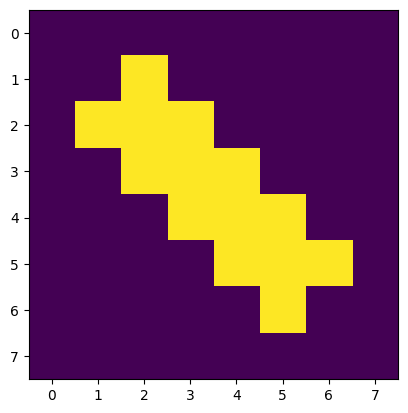

In [4]:
#PASO 2: Cargar la imágen y convertirla a binario [0,1]

'''USAR IMAGENES CUADRADAS'''
image_location=r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\image.jpg'      
img = cv2.imread(image_location,0)   #Se lee la imagen en escala de grises (1 canal)
ret, bw_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY) #se pasa la imagen a binarios(blanco y negro)
bw_img=(1/255)*bw_img    #el binario de [0,255] pasa a ser [0,1].
plt.imshow(bw_img)
print('tamaño del watermark : '+ str(bw_img.shape))
alto = (len(bw_img[0]))  
ancho = (len(bw_img[:]))
bits_totales = alto * ancho

True

C:\Users\Julian\AppData\Local\Temp\ipykernel_37448\2168319273.py:14: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(t, f, np.log10(np.abs(audio_stft)))


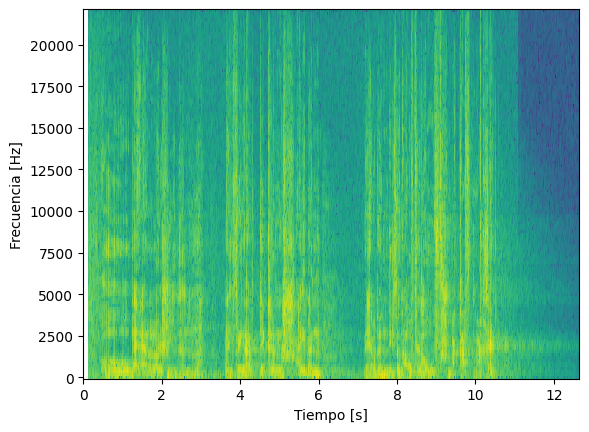

In [5]:
#PASO 3: Se obtiene la matriz STFT del audio a marcar

Ventana ='blackman'                                      #CAMBIAR ACÁ EL TIPO DE VENTANA PARA LA STFT
m = 256              #ancho de la ventana
overlap = m // 2
nfft=m
return_onesided = True

f,t,audio_stft = sg.stft(audio,fs=fs_audio,window=Ventana,nperseg=m,nfft=nfft,noverlap=overlap,return_onesided=return_onesided)

fig,ax = plt.subplots()
ax.set_ylabel('Frecuencia [Hz]')
ax.set_xlabel('Tiempo [s]')
ax.pcolormesh(t, f, np.log10(np.abs(audio_stft)))

print(sg.check_NOLA(Ventana,m,overlap))

In [6]:
#PASO 4: Proceso de Marcado del audio

bps = bits_totales

frame_width = (overlap // bps)        # Ancho del frame

a = 0.015                             # factor de fuerza

watermarkBits = bw_img.flatten()      # Pasamos la imagen de matriz a array.

Dxx = np.zeros(audio_stft.shape,dtype=float64)

noise = np.random.normal(0,0.1,size=(frame_width,len(t)))      #Se genera la matriz con el pseudo ruido.
noise[noise == 0] = 0.05             #Para evitar errores en la detección por división sobre cero, se reemplazan los posibles ceros por otro valor no nulo (en este caso 0.05).

Resultado = audio_stft

ind = np.arange(0, len(audio_stft)-frame_width+1, frame_width, dtype = int)    # Determinamos donde empezamos a fragmentar la STFT

# Por cada frame:
for f in range(len(ind)):

    frame = audio_stft[ind[f]:ind[f]+frame_width]

    u, d, vt = np.linalg.svd(frame,full_matrices=True) # SVD de cada Frame
    d = scipy.linalg.diagsvd(d,len(u),len(vt))

    w = noise

    delta_i = np.zeros(d.shape,dtype=float)
    for i in range( len(d) ):
        delta_i[i]= d[i,i]


    wd=[]
    for i in range( len(d) ):
        bit = watermarkBits[f]
        wd.append(array(d[i]+a*w[i]*bit))

    wd = np.array(wd)
    
    uw, dw, vwt = np.linalg.svd(wd,full_matrices=True)
    dw = scipy.linalg.diagsvd(dw,len(uw),len(vwt))
    
    
    Dxx[ind[f]:ind[f]+frame_width] = np.matmul(np.matmul(uw,d),vwt)         # "Uw", "D" y "Vwt" de cada Frame se guardan en este archivo para la posterior detección.
   
    Resultado[ind[f]:ind[f]+frame_width] = np.matmul(np.matmul(u,dw),vt)          # Frame de STFT marcado.

    
Resultado=np.array(Resultado)

                             

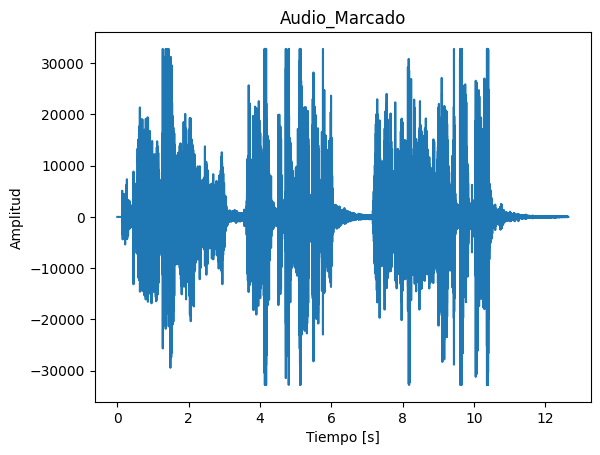

In [7]:
#PASO 5: Inversa de la STFT para obtener el audio marcado

n_audio_marcado, audio_marcado = sg.istft(Resultado,fs=fs_audio,window=Ventana,nperseg=m,noverlap=overlap,nfft=nfft,input_onesided=return_onesided)    #SALE EL AUDIO MARCADO

plt.figure()
plt.plot(n_audio_marcado,audio_marcado)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.title('Audio_Marcado')  
plt.show()


In [8]:
#PASO 6: Exportamos los resultados

np.savetxt("Dxx.csv", Dxx, delimiter=",")         #Se guarda la matriz svd del audio original.
np.savetxt("key.csv", noise, delimiter=",")       #Se guarda la contraseña.
np.savetxt("bps.csv", np.array([bps,0]), delimiter=",")     #Se guardan los bps.
np.savetxt("audio_original.csv", audio, delimiter=",")
np.savetxt("strength_factor.csv", np.array([a,0]), delimiter=",")
audio_marcado = audio_marcado/np.max(np.abs(audio_marcado))     #Se normaliza el resultado
audio_marcado = np.iinfo(np.int16).max*audio_marcado
wav.write('audio_marcado.wav',fs_audio,audio_marcado.astype(np.int16))  #Se exporta el audio marcado
IPython.display.Audio("audio_marcado.wav")

In [9]:
'''
FASE DE PRUEBAS: FALSA CONTRASEÑA
'''

false_key = np.random.normal(0,0.1,size=(frame_width,len(t)))      #Se genera otro pseudo ruido aleatorio.
np.savetxt("false_key.csv", false_key, delimiter=",")    